# Lesion Attribute Detection - Part 2

In [1]:
## Imports
import os
import sys
import random
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [2]:
from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing
from segmentation_models.metrics import iou_score
from segmentation_models.losses import jaccard_loss

Using TensorFlow backend.
C:\Users\alessandra\Anaconda3\envs\PythonGPU1\lib\site-packages\classification_models\resnext\__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [3]:
## Seeding 
seed = 201
random.seed = seed
np.random.seed = seed
tf.seed = seed

## Data Generator - globules features

In [4]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, m_path, image_size, backbone='inceptionresnetv2', batch_size=2 ):
        self.ids = ids
        self.path = path
        self.m_path = m_path
        self.backbone = backbone
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name) + ".jpg"
        mask_path = os.path.join(self.m_path, id_name)+ "_attribute_globules.png"
        
        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = cv2.imread(mask_path, -1)
        mask = cv2.resize(mask, (self.image_size, self.image_size))
        mask = np.expand_dims(mask, axis=-1)
            
        ## Normalizaing
        preprocess_input = get_preprocessing(self.backbone)
        image = preprocess_input(image)         # Subtract the mean of the ImageNet dataset where ResNet is pre-trained
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [13]:
image_size = 384 #suggested 384x576
train_path = "./train_set/"
train_path_mask = "./masks_set/"

epochs = 1
batch_size = 1
## Training Ids
train_ids = next(os.walk("./train_set/"))[2]
train_ids = [os.path.splitext(x)[0] for x in train_ids]

## Validation Data Size
val_data_size = 100

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

## Train - validation generator

In [14]:
train_gen = DataGen(train_ids, train_path, train_path_mask, backbone='inceptionresnetv2', image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, train_path_mask, backbone='inceptionresnetv2',image_size=image_size, batch_size=1)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

In [15]:
x, y = valid_gen.__getitem__(0)
print(x.shape, y.shape)

(1, 384, 384, 3) (1, 384, 384, 1)


# U-Net

In [8]:
model = Unet(backbone_name='inceptionresnetv2', input_shape=(image_size, image_size, 3), classes=1, activation='relu', 
             encoder_weights='imagenet', encoder_freeze=False, encoder_features='default', decoder_block_type='upsampling',
             decoder_filters=(256, 128, 64, 32, 16), decoder_use_batchnorm=True)

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
model.compile(optimizer='Adam', metrics =[iou_score], loss = jaccard_loss)

In [11]:
model

In [16]:
# fit model
model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps,epochs=epochs)

ValueError: `validation_data` should be a tuple `(val_x, val_y, val_sample_weight)` or `(val_x, val_y)`. Found: <__main__.DataGen object at 0x0000000B42304EB8>

## Test the model

In [11]:
## Save the Weights
model.save_weights("UNetW.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(2)
result = model.predict(x)

result = result > 0.5

In [22]:
result.shape

(1, 128, 128, 5)

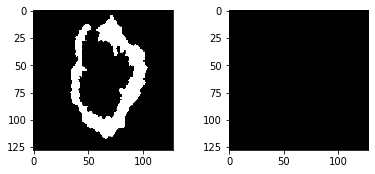

In [13]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[:,:,:,3]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[:,:,:,3]*255, (image_size, image_size)), cmap="gray")